In [29]:
import sys
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from skimage import io, filters
import numpy as np

##import 
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
import utils
import plotting
import responses_analysis
import dfof
import numpy as np
import config

save_path = config.save_path
data_path = config.data_path
if not save_path.exists():
    save_path.mkdir()

In [30]:
test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)
mice = utils.groupData(dir=data_path, analysis_file_name = "wfstack_3.pkl").mice

**/2P/L23/[0-9]* all


In [31]:
###load up widefield example for overview panel
example_mouse = 'm670'
ex = mice[mice['Mouse']==example_mouse]
folder = Path(ex['path'].values[0])
frameToTake = 45

mean_file = folder / "fig_analysis/mean_stack.npy"
if not mean_file.exists():
    wfstack = utils.widefieldStack(dir=folder)
    wfstack.unmix()
    wfstack.removeAnamolies()
    freqToTake = [0]
    numBaseline = 30 
    frameToTake = 45

    mean_stack = np.nanmean(wfstack.unmixed[:,:,:,[0,2,4],1,:],axis=-1)
else:
    mean_stack = np.load(mean_file,allow_pickle=True)

bl = np.nanmean(mean_stack[:30,:,:],axis=0)

blsubt = mean_stack - bl
prctiles = np.percentile(blsubt[frameToTake,:,:],q=99,axis=(0,1))
norm = np.divide(blsubt,prctiles)
norm[norm < 0] = 0
norm[norm > 1] = 1

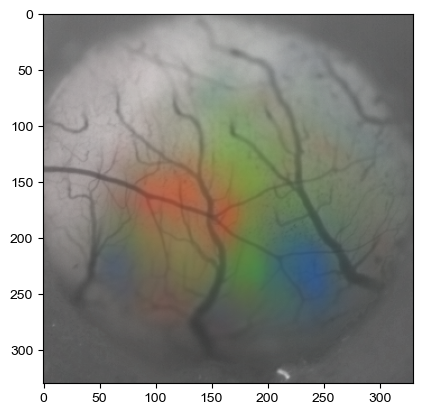

In [32]:
low_freq = filters.gaussian(norm[frameToTake,:,:,0],5)
med_freq = filters.gaussian(norm[frameToTake,:,:,1],5)
high_freq = filters.gaussian(norm[frameToTake,:,:,2],5)

overlay = np.zeros(shape=(low_freq.shape[0],low_freq.shape[0],4))
overlay[:,:,2] = low_freq
overlay[:,:,1] = low_freq * 0.3
overlay[:,:,3] = low_freq / 1.5

plt.imshow(mean_stack[:30,:,:].mean(axis=(0,-1)),cmap='gray',vmin=1000)
plt.imshow(overlay, vmin=0, vmax=0.5)

overlay = np.zeros(shape=(low_freq.shape[0],low_freq.shape[0],4))
overlay[:,:,2] = 0
overlay[:,:,1] = med_freq
overlay[:,:,3] = med_freq / 2
plt.imshow(overlay)

overlay = np.zeros(shape=(low_freq.shape[0],low_freq.shape[0],4))

overlay[:,:,0] = high_freq
overlay[:,:,3] = high_freq / 2
plt.imshow(overlay)
plt.savefig(save_path / ("Fig3A_three_freqs_example_" +example_mouse+ ".svg"))


In [33]:
###load up 2P example for overview panel
analysis_dir = twop_mice[twop_mice['Mouse']==example_mouse]['2P_path'].values[0] / "analysis_fig"
if not analysis_dir.exists():
    analysis_dir.mkdir()
analysis_file = analysis_dir / "2p_mean_stack.npy"

if not analysis_file.exists():
    twop_mice[twop_mice['Mouse']==example_mouse]
    twopstack = utils.widefieldStack(dir = twop_mice[twop_mice['Mouse']==example_mouse]['2P_path'].values[0])
    twopstack.stack = twopstack.__loadStack__()
    twopstack.stack = utils.imresize(twopstack.stack,(512,512))
    twopstack.unmix()
    mean_stack = np.nanmean(twopstack.unmixed[:,:,:,[0,2,4],2,:],axis=-1)
    np.save(analysis_file, mean_stack)
else:
    mean_stack = np.load(analysis_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


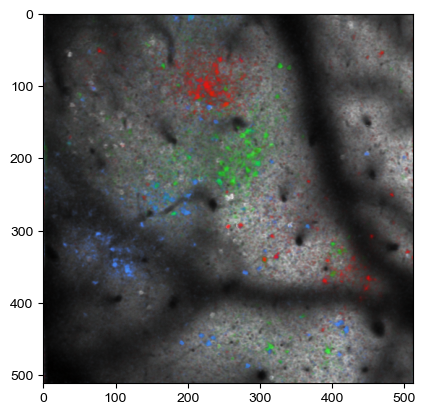

In [34]:
frameToTake = 43
bl = np.nanmean(mean_stack[:30,:,:],axis=0)
blsubt = mean_stack - bl
prctiles = np.percentile(blsubt[frameToTake,:,:],q=99.5,axis=(0,1))
norm = np.divide(blsubt,prctiles)
norm[norm < 0] = 0
norm[norm > 1] = 1
gauss_size = 1
low_freq = filters.gaussian(norm[frameToTake,:,:,0],gauss_size)
med_freq = filters.gaussian(norm[frameToTake,:,:,1],gauss_size)
high_freq = filters.gaussian(norm[frameToTake,:,:,2],gauss_size)

overlay = np.zeros(shape=(low_freq.shape[0],low_freq.shape[0],4))
overlay[:,:,2] = low_freq + .3
overlay[:,:,0] = 0.3
overlay[:,:,1] = low_freq * 0.3 + 0.3
overlay[:,:,3] = low_freq *1.2

plt.imshow(mean_stack.mean(axis=(0,-1)),cmap='gray',vmin=0,vmax=1500)
plt.imshow(overlay)

overlay = np.zeros(shape=(low_freq.shape[0],low_freq.shape[0],4))
overlay[:,:,2] = 0
overlay[:,:,1] = med_freq
overlay[:,:,3] = med_freq / 1.5
plt.imshow(overlay)

overlay = np.zeros(shape=(low_freq.shape[0],low_freq.shape[0],4))

overlay[:,:,0] = high_freq
overlay[:,:,3] = high_freq / 1.2
plt.imshow(overlay)
plt.savefig(save_path / ("Fig3_A_2P_with_colors" + example_mouse + ".svg"))

88        88
16        16
109      109
177      177
106      106
        ... 
1188    1188
75        75
538      538
892      892
1449    1449
Name: neuron, Length: 694, dtype: int64
10


<Figure size 200x150 with 0 Axes>

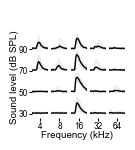

In [35]:
###okay now get the neuron data
twop_mice[twop_mice['Mouse']==example_mouse]
path = twop_mice[twop_mice['Mouse']==example_mouse]['2P_path'].values[0]
twop_unmixed = np.load(path / "response_analysis/unmixed.npy")
isResponsive = pd.read_csv(path / "response_analysis/isResponsive.csv")
print(isResponsive[isResponsive['isResponsive']==True].sort_values(by='PR(>F)')['neuron'])

plt.figure(figsize=(2,1.5))
fig, axs = plotting.plotFRAtraces(twop_unmixed[177,:,:,:],ymin=-5, ymax=50, xmin=0, xmax=60, convolve_len=3)
fig.set_figheight(1.4)
fig.set_figwidth(1.2)
fig.supxlabel("Frequency (kHz)", fontsize=7, y = -0.05)
fig.supylabel("Sound level (dB SPL)", fontsize=7, x=-0.06, y = 0.4)

plt.savefig(save_path / ("Fig3_B_individual_response_" + example_mouse + ".svg"))

In [36]:
###now average for everyone
test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)
avg_response = []

force = False
for index, row in twop_mice.iterrows():
    print(row['Mouse'])
    analysis_dir = row['2P_path'] / "response_analysis"
    if not analysis_dir.exists():
        (row['2P_path'] / "response_analysis").mkdir()

    if (analysis_dir / "unmixed.npy").exists():
        unmixed = np.load(analysis_dir / "unmixed.npy")
    else:
        temp = dfof.processFluor(dir = row['2P_path'])
        temp.loadTraces()
        temp.calc_dfof(window=500, step = 50, percentile=10, cutoff = 20)
        temp.unmix(numBaseline=15, framesAfter=60)
        np.save(analysis_dir / "unmixed.npy", temp.unmixed)

    responsive_file = analysis_dir / "isResponsive.csv"
    if responsive_file.exists() and not force:
        isResponsive = pd.read_csv(responsive_file)
    else:
        isResponsive = responses_analysis.isResponsive(unmixed, alpha = 0.01)
        isResponsive.to_csv(responsive_file, index=False)
    
    responsive_neurons = np.array(isResponsive[isResponsive['isResponsive']==True]['neuron'])
    unmixed[responsive_neurons,:].mean(axis=(0,-1))
    avg_response.append(unmixed[responsive_neurons,:].mean(axis=(0,-1)))

twop_mice['averageResponse']=avg_response

**/2P/L23/[0-9]* all
m602
m603
m609
m670
m674
m675
m659
m722
m664
m666
m900
m984
m985
m1315
m1321
m1318
m1323
m1493
m1937
m2065
m1983


8
Thy1-GC6s; Cdh23 (Ahl/ahl)
8
Thy1-GC6s; Cdh23 (ahl/ahl)
5
(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)


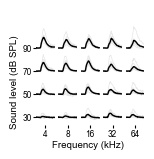

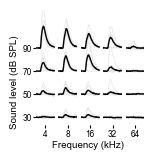

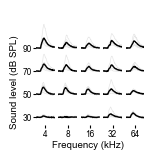

In [37]:
geno_dict ={'Thy1-GC6s; Cdh23 (Ahl/ahl)':'AhlB6','Thy1-GC6s; Cdh23 (ahl/ahl)':'B6', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)':'AhlCBA'}
for i, genotype in enumerate(twop_mice['Genotype'].unique()):
    temp = twop_mice[twop_mice['Genotype']==genotype]
    temp_traces = np.stack(temp['averageResponse'],axis=-1)
    temp_traces = temp_traces - temp_traces[0:15,:].mean(axis=0)
    fig, axs = plotting.plotFRAtraces(temp_traces, ymin = -1, ymax = 5, xmin=0, xmax=60)
    fig.set_figheight(1.5)
    fig.set_figwidth(1.4)
    fig.supxlabel("Frequency (kHz)", fontsize= 7, y = -0.05)
    fig.supylabel("Sound level (dB SPL)", fontsize=7, x=-0.06, y = 0.4)
    print(genotype)
    plt.savefig(save_path / ("Fig3_D_" + geno_dict[genotype] + "_group_data.svg"), dpi=900)